### CSE 6367 Programming Assignment 4 (P4)
## Fall 2023
## Panorama

## Dataset

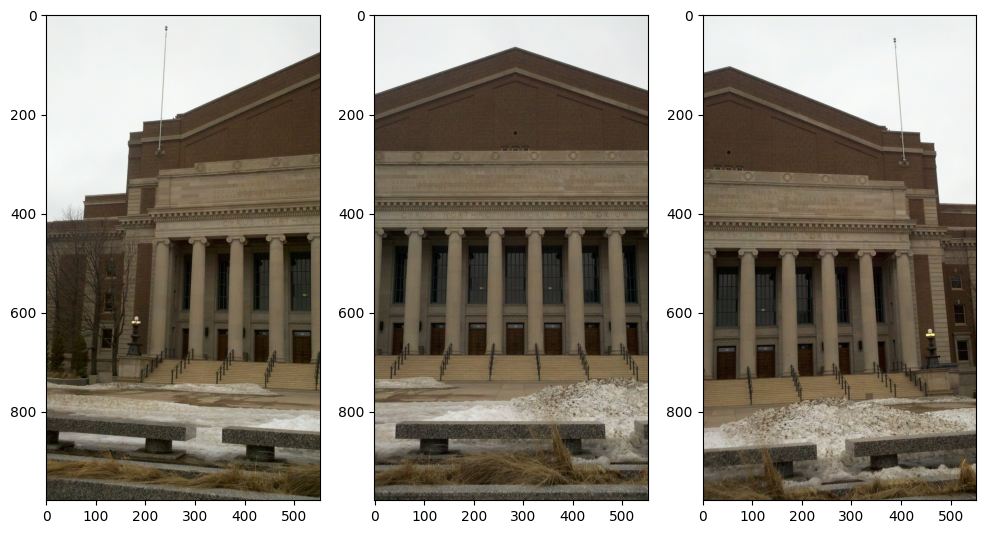

In [1]:
import cv2
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 12 ,8

# read images
img1 = cv2.imread("Images/mall1.jpg")
img2 = cv2.imread("Images/mall2.jpg")
img3 = cv2.imread("Images/mall3.jpg")

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

# display images
fig, ax = plt.subplots(1,3)
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[2].imshow(img3)

## Assignment Instructions:

In this assignment, you will perform image stitching and create a panorama of stitched images. Here are some basic steps you need to perform for image stiching:

    1. Detecting keypoints (DoG, Harris, etc.) and extracting local invariant descriptors (SIFT, SURF, ORB etc.) from two input images
    2. Matching the descriptors between the images
    3. Estimate a homography matrix using our matched feature vectors
    4. Applying a warping transformation using the homography matrix obtained from Step #3
    
<b> You may use opencv or other libraries for doing different tasks of this programming assignment.<\b>

### Step1: SIFT keypoints and descriptors using detectAndCompute()

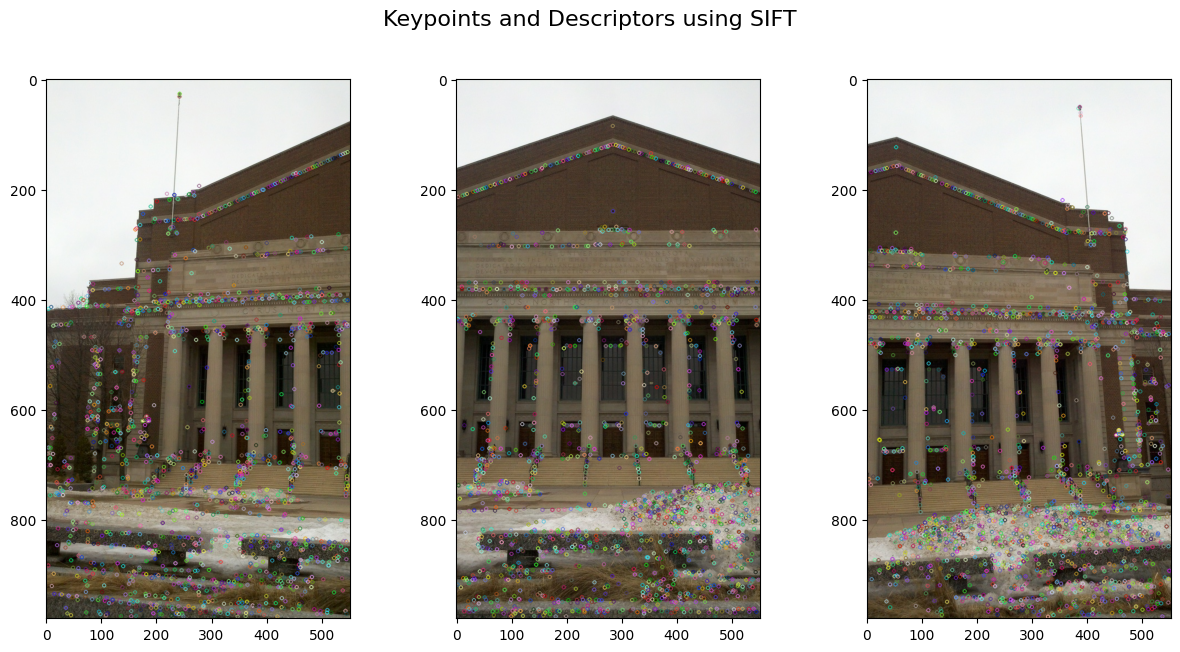

In [2]:
sift = cv2.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)
keypoints_3, descriptors_3 = sift.detectAndCompute(img3, None)

img_1 = cv2.drawKeypoints(img1,keypoints_1,None)
img_2 = cv2.drawKeypoints(img2,keypoints_2,None)
img_3 = cv2.drawKeypoints(img3,keypoints_3,None)

# Showing keypoints and descriptors for each of the 3 images
plt.figure(figsize=(15,7))
plt.suptitle('Keypoints and Descriptors using SIFT', fontsize=16)
plt.subplot(1,3,1)
plt.imshow(img_1)
plt.subplot(1,3,2)
plt.imshow(img_2)
plt.subplot(1,3,3)
plt.imshow(img_3)
plt.show()

### Step2: Matching the extracted SIFT features using K-NN (k=4)

272 472


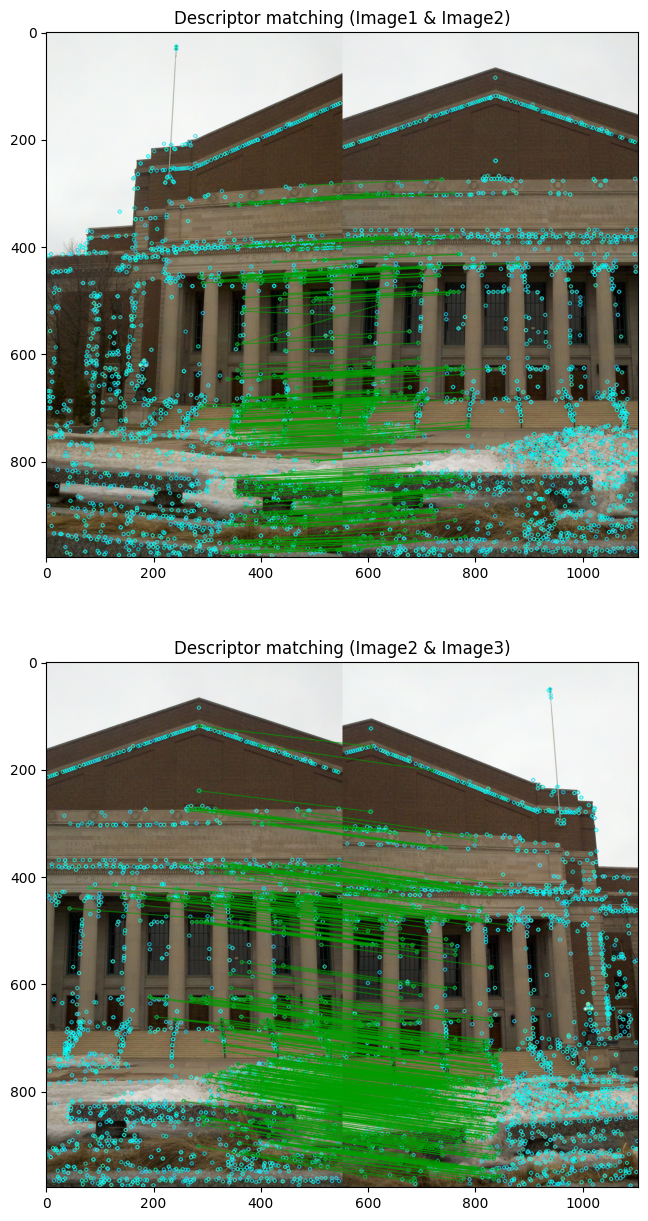

In [9]:
bf = cv2.BFMatcher()
matches12 = bf.knnMatch(descriptors_1, descriptors_2, k=2)
matches23 = bf.knnMatch(descriptors_2, descriptors_3, k=2)

good_matches_12 = []
for m, n in matches12:
    if m.distance < 0.60 * n.distance:
        good_matches_12.append([m])

good_matches_23 = []
for m, n in matches23:
    if m.distance < 0.60 * n.distance:
        good_matches_23.append([m])

print(len(good_matches_12), len(good_matches_23))
match_image_12 = cv2.drawMatchesKnn(img_1, keypoints_1, img_2, keypoints_2, good_matches_12, outImg=None, matchColor=(0, 155, 0),
                             singlePointColor=(0, 255, 255), matchesMask=None, flags=0)

match_image_23 = cv2.drawMatchesKnn(img_2, keypoints_2, img_3, keypoints_3, good_matches_23, outImg=None, matchColor=(0, 155, 0),
                             singlePointColor=(0, 255, 255), matchesMask=None, flags=0)

plt.figure(figsize=(10,15))
plt.subplot(211)
plt.imshow(match_image_12)
plt.title('Descriptor matching (Image1 & Image2)')
plt.subplot(212)
plt.imshow(match_image_23)
plt.title('Descriptor matching (Image2 & Image3)')
plt.show()

### Step3: Estimating Homography matrix

In [10]:
# Extract matched keypoints from good matches

def estimate_homography(keypoints1, keypoints2, matches, threshold=3):
    src_pts = np.float32([keypoints1[m[0].queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m[0].trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, threshold)
    return H, mask

H1, mask = estimate_homography(keypoints_1, keypoints_2, good_matches_12)
H2, mask = estimate_homography(keypoints_2, keypoints_3, good_matches_23)

print('H1:', H1)
print('H2:', H2)

H1: [[ 1.16296303e+00 -2.53783608e-02 -3.43322285e+02]
 [ 1.54883560e-01  1.12888804e+00 -8.55648736e+01]
 [ 2.76807815e-04  6.96655454e-06  1.00000000e+00]]
H2: [[ 1.10835487e+00 -1.47678487e-02 -2.57005298e+02]
 [ 1.06583277e-01  1.05911114e+00  8.79527587e+00]
 [ 2.04899284e-04 -2.38074196e-05  1.00000000e+00]]


### Step4: Warping images using Homography matrix

(1099, 918, 3) (1071, 808, 3)


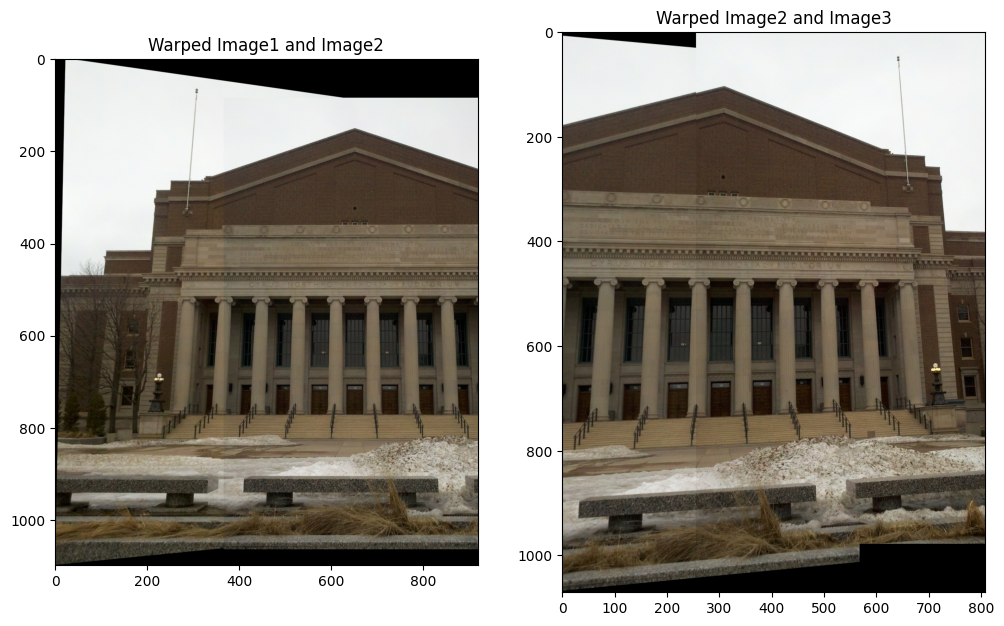

In [11]:
def warp_images(img1, img2, H):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    corners1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    corners2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    warped_corners2 = cv2.perspectiveTransform(corners2, H)

    corners = np.concatenate((corners1, warped_corners2), axis=0)
    [xmin, ymin] = np.int32(corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(corners.max(axis=0).ravel() + 0.5)

    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])

    warped_img2 = cv2.warpPerspective(img2, Ht @ H, (xmax - xmin, ymax - ymin))
    warped_img2[t[1]:h1 + t[1], t[0]:w1 + t[0]] = img1

    return warped_img2

warped_img_12 = warp_images(img2, img1, H1)
warped_img_23 = warp_images(img3, img2, H2)

# Mannually adjusting  warped_img_23 height and width to get proper panorama(NOTHING ELSE)
warped_img_23 = warped_img_23[:, 22:]
print(warped_img_12.shape, warped_img_23.shape)

plt.subplot(1,2,1)
plt.imshow(warped_img_12)
plt.title('Warped Image1 and Image2')
plt.subplot(1,2,2)
plt.imshow(warped_img_23)
plt.title('Warped Image2 and Image3')
plt.show()

### STEP 5: Repeat step 4 for Image_12 and Image_23. Find keypoints and descriptors for above two images and match their SIFT descriptors to merge both images

350


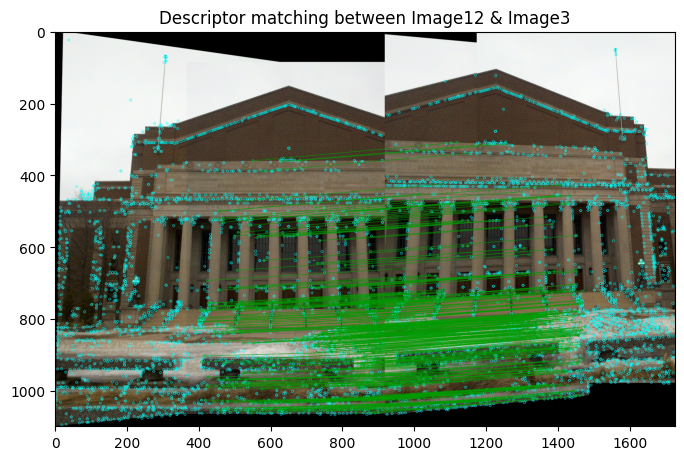

H12: [[ 1.25253167e+00 -2.26372862e-02 -4.57478811e+02]
 [ 1.14305355e-01  1.14352803e+00 -1.31023235e+02]
 [ 2.20267766e-04 -2.47124817e-05  1.00000000e+00]]


In [21]:
keypoints_12, descriptors_12 = sift.detectAndCompute(warped_img_12, None)
keypoints_23, descriptors_23 = sift.detectAndCompute(warped_img_23, None)

bf = cv2.BFMatcher()
matches_12_3 = bf.knnMatch(descriptors_12, descriptors_23, k=2)

good_matches_12_3 = []
for m, n in matches_12_3:
    if m.distance < 0.30 * n.distance:
        good_matches_12_3.append([m])

print(len(good_matches_12_3))
match_image_12_3 = cv2.drawMatchesKnn(warped_img_12, keypoints_12, warped_img_23, keypoints_23, good_matches_12_3, outImg=None, matchColor=(0, 155, 0),
                             singlePointColor=(0, 255, 255), matchesMask=None, flags=0)

plt.figure(figsize=(8,8))
plt.imshow(match_image_12_3)
plt.title('Descriptor matching between Image12 & Image3')
plt.show()

H12, mask = estimate_homography(keypoints_12, keypoints_23, good_matches_12_3)

print('H12:', H12)
# warped_img_12_3 = warp_images(warped_img_23, warped_img_12, np.dot(H1, H2))
warped_img_12_3 = warp_images(warped_img_23, warped_img_12, H12)

### STEP 6: Final Panorama image

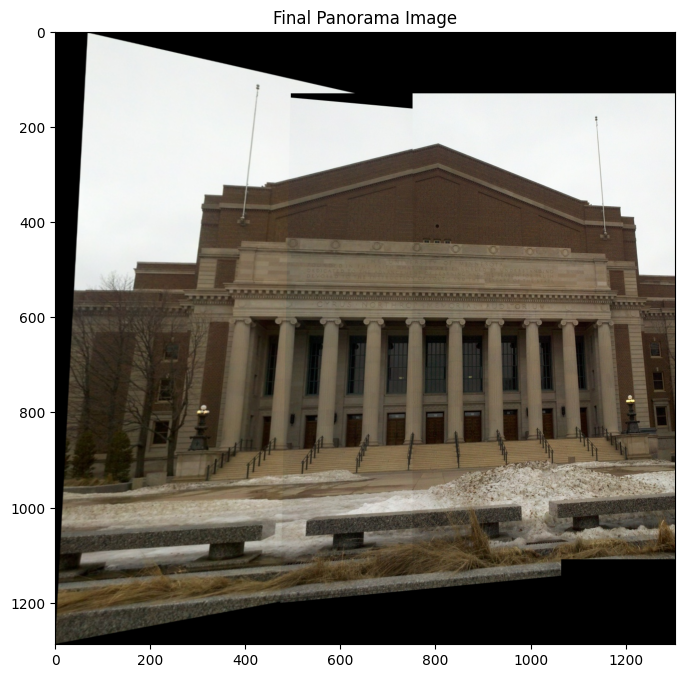

In [22]:
panorama_image = warped_img_12_3

plt.figure(figsize=(8,8))
plt.imshow(panorama_image)
plt.title('Final Panorama Image')
plt.show()

### IDEAL CASE: Used library function directly to stitch to show the similarity between my output with the library output (PLEASE DISCARD BELOW SNIPPET WHILE GRADING)

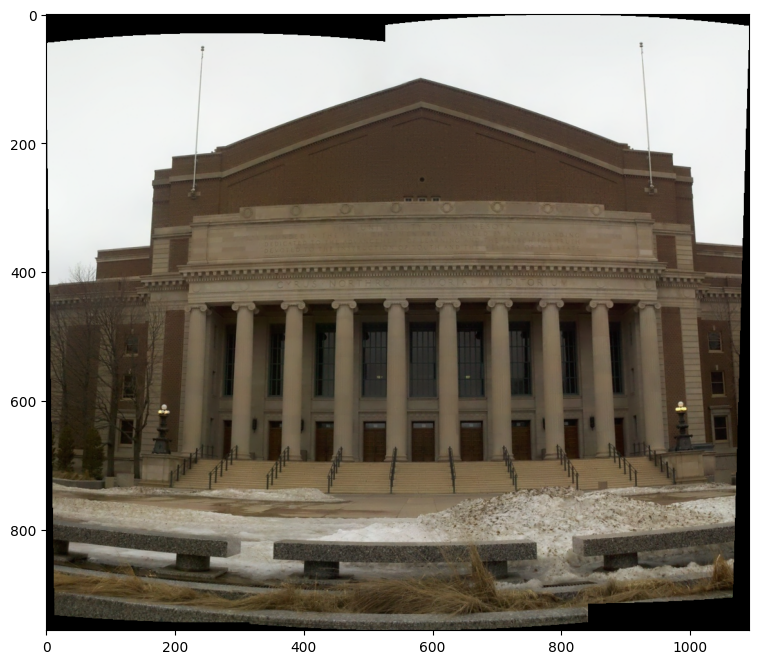

In [8]:
stitcher = cv2.Stitcher.create(cv2.Stitcher_PANORAMA)

images=[img1, img2, img3]
status, panorama = stitcher.stitch(images)

if status == cv2.Stitcher_OK:
    plt.imshow(panorama)
    plt.show()
else:
    print("Error during stitching:", status)

### Submission Guidelines:
        
        Submit through Canvas your source code in a single .ipynb file. 
        The name of the .ipynb file should be YourStudentID.ipynb. (For example: 1001234567.ipynb)
        The images are available in the ./Images directory. Your TA will use the same directory name to grade your submission.
        You don't need to attach the images folder with your submission.

## References

1. Keypoints and descriptors: https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html
2. SIFT behind the scenes understanding: https://www.analyticsvidhya.com/blog/2019/10/detailed-guide-powerful-sift-technique-image-matching-python/
3. Panoramic image stitching detailed paper: http://matthewalunbrown.com/papers/ijcv2007.pdf
4. OpenCV tutorial to merge 2 images: https://www.opencvhelp.org/tutorials/advanced/image-stitching/